In [24]:
# data loading and deep learning
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support
from torch.utils.data import random_split

# model metrics visualization
import matplotlib.pyplot as plt

In [2]:
# get tremor data (.npz file) from drive
# link: https://drive.google.com/file/d/1KJx9-cy2u6Dv3KyotrhhXGRQ0vCWjo5Q/view?usp=drive_link
!pip install gdown
import gdown

file_id = "1KJx9-cy2u6Dv3KyotrhhXGRQ0vCWjo5Q"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "tremor_data.npz", quiet=False)

data = np.load('tremor_data.npz')
print(data.files)

Downloading...
From: https://drive.google.com/uc?id=1KJx9-cy2u6Dv3KyotrhhXGRQ0vCWjo5Q
To: /content/tremor_data.npz
100%|██████████| 21.3M/21.3M [00:00<00:00, 101MB/s]

['features', 'labels']


Data is comprised of **feature arrays** and **label arrays** which have already been processed. Features are in 3 second segments, sampled at 100Hz so 300 data points, and across 3 dimensional channels, x y z.

In [3]:
print(f"Feature array shape: {data['features'].shape}")
print(f"Label array shape: {data['labels'].shape}")

Feature array shape: (3091, 300, 3)
Label array shape: (3091,)


In [4]:
counts = np.unique(data['labels'], return_counts=True)
class_name = {0: 'non-tremor', 1: 'pre-tremor', 2: 'tremor'}
label_counts = {class_name[int(lbl)]: int(count) for lbl, count in zip(counts[0], counts[1])}
print(f"Label Distribution: {label_counts}")

Label Distribution: {'non-tremor': 2997, 'pre-tremor': 28, 'tremor': 66}


There are unexpectly a serious **class imbalance issue**, where non-tremor (label 0) has a greater presence than pre-tremor (label 1) and tremor (label 2). Something we can do before even training is **downsample the dominant class**, 'non-tremor'.

In [5]:
def downsample(signal, labels, percent_tremor=10):
    '''
    percent_tremor: Percent of samples that are labeled either 'pre-tremor' (1) or 'tremor' (2) in the downsampled dataset.
    '''
    count = np.unique(labels, return_counts=True)[1]
    num_tremor = count[1] + count[2]
    # adjust non tremor sample count
    num_non_tremor = int((num_tremor / percent_tremor) * 100) - num_tremor
    print(f'Downsampling to {num_non_tremor} of non-tremor samples from {count[0]}')
    print(f'Downsampled set has {num_tremor} amount of positive tremor labels.')

    if len(labels) - num_tremor < num_non_tremor:
        print(f"Chosen percent_tremor: {percent_tremor} is upsampling 'non_tremor' cases.")
        return signal, labels
    else:
        # get indicies of each sample with respective label
        zero_mask = labels == 0
        tremor_mask = labels !=0

        # randomly select 'non_tremor' samples to keep
        kept_zeroes = np.random.choice(np.where(zero_mask)[0], num_non_tremor, replace=False)
        kept_sample_idx = np.concatenate((kept_zeroes, np.where(tremor_mask)[0]))
        shuffled_idx = np.random.permutation(kept_sample_idx)

        return signal[shuffled_idx], labels[shuffled_idx]

In [6]:
downsampled_signal, downsampled_labels = downsample(data['features'], data['labels'], percent_tremor=10)
print(f"Downsampled Feature array shape: {downsampled_signal.shape}")
print(f"Downsampled Label array shape: {downsampled_labels.shape}")

Downsampling to 846 of non-tremor samples from 2997
Downsampled set has 94 amount of positive tremor labels.
Downsampled Feature array shape: (940, 300, 3)
Downsampled Label array shape: (940,)


Create PyTorch dataset for tremor data.

In [7]:
class TremorDataset(Dataset):
    def __init__(self, signal, labels):
        '''
        signal (ndarray): 3D array of shape (num_samples, num_points, num_channels)
        labels (ndarray): 1D array of shape (num_samples,)
        '''
        # change signal dimension to (num_samples, num_channels, num_points) since 1D Conv passes over lowest dimension
        self.signal = torch.tensor(signal, dtype=torch.float32).permute(0, 2, 1)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.signal[idx], self.labels[idx]

In [8]:
dataset = TremorDataset(downsampled_signal, downsampled_labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(20))

# create dataloaders, only using train and val for proof of concept
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# one batch
signal_batch, label_batch = next(iter(train_loader))
print(signal_batch.shape) # expecting (B, channels, sequence) -> (B, 3, 300)
print(label_batch.shape) # expecting (B)

torch.Size([16, 3, 300])
torch.Size([16])


# **Model: 1D CNN**

In [9]:
'''GPT generated code'''
class TremorCNN(nn.Module):
    def __init__(self, num_channels=3, num_classes=3):
        super(TremorCNN, self).__init__()

        # Conv1: in_channels=3 (x,y,z), out_channels=16, kernel_size=5
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=16, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(16)

        # Conv2: 16 -> 32
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(32)

        # Adaptive pooling to fix output length
        self.pool = nn.AdaptiveMaxPool1d(50)  # output length = 50

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 50, 64)
        self.fc2 = nn.Linear(64, num_classes)  # num_classes = 3 (0,1,2)

    def forward(self, x):
        # x: (batch_size, 3, sequence_length)
        x = F.relu(self.bn1(self.conv1(x)))   # -> (batch, 16, L1)
        x = F.relu(self.bn2(self.conv2(x)))   # -> (batch, 32, L2)
        x = self.pool(x)                       # -> (batch, 32, 50)
        x = x.view(x.size(0), -1)             # flatten -> (batch, 32*50)
        x = F.relu(self.fc1(x))               # -> (batch, 64)
        x = self.fc2(x)                       # -> (batch, num_classes)
        return x

# **Train**

In [46]:
label, count = np.unique(downsampled_labels, return_counts=True)
class_weights = torch.tensor(1.0 / count, dtype=torch.float32)
class_weights /= class_weights.sum() # normalize so training loss is easier to read (not scaled ny 1e-3 or so)

def train_model(model, train_loader, val_loader, class_weights, epochs=5, lr=1e-2):
    # using weighted loss to mitigate effects of having less tremor labels than 'non-tremor'
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    model_details = {'model': {str(model)}, 'lr': {lr}, 'epochs': {epochs}}
    # to plot later
    metrics = {'train_loss': [], 'train_precision': [], 'train_recall': [], 'train_f1': [],
               'val_loss': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        epoch_pred = []
        all_labels = []

        #---------
        # TRAINING
        #---------
        for signals, labels in train_loader:
            signals, labels = signals.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_pred = torch.argmax(outputs, dim=1)
            # each batch, get associated predictions and labels to compute confusion matrix metrics per epoch
            epoch_pred.extend(batch_pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(labels)
        # these metrics better than accuracy for class imbalance
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, epoch_pred, average=None, zero_division=0)

        # train metrics for the tremor class
        tremor_labels = [1,2]
        precision = precision[tremor_labels].mean()
        recall = recall[tremor_labels].mean()
        f1 = f1[tremor_labels].mean()

        print(f'Epoch {epoch}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Precision: {precision:.4f} | Train Recall: {recall:.4f} | F1: {f1:.4f}')

        #-----------
        # VALIDATION
        #-----------

        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for signals, labels in val_loader:
                signals, labels = signals.to(device), labels.to(device)
                outputs = model(signals)
                batch_pred = torch.argmax(outputs, dim=1)
                val_preds.extend(batch_pred.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average=None, zero_division=0)

        # val metrics for tremor class
        val_precision = val_precision[tremor_labels].mean()
        val_recall = val_recall[tremor_labels].mean()
        val_f1 = val_f1[tremor_labels].mean()

        print(f'Epoch {epoch}/{epochs} | Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}\n')

        # append all metrics
        metrics['train_loss'].append(epoch_loss)
        metrics['train_precision'].append(precision)
        metrics['train_recall'].append(recall)
        metrics['train_f1'].append(f1)
          # note: didn't add val_loss
        metrics['val_precision'].append(val_precision)
        metrics['val_recall'].append(val_recall)
        metrics['val_f1'].append(val_f1)

    return (model, metrics)

In [47]:
model = TremorCNN()
model_v1param, metrics_v1param = train_model(model, train_loader, val_loader, class_weights, epochs=50, lr=1e-2)

Epoch 1/50 | Train Loss: 6.8313 | Train Precision: 0.1291 | Train Recall: 0.3278 | F1: 0.1842
Epoch 1/50 | Val Precision: 0.1667 | Val Recall: 0.3750 | Val F1: 0.2308

Epoch 2/50 | Train Loss: 2.2999 | Train Precision: 0.1797 | Train Recall: 0.4046 | F1: 0.2468
Epoch 2/50 | Val Precision: 0.1351 | Val Recall: 0.4167 | Val F1: 0.2041

Epoch 3/50 | Train Loss: 2.1778 | Train Precision: 0.2230 | Train Recall: 0.4546 | F1: 0.2968
Epoch 3/50 | Val Precision: 0.1364 | Val Recall: 0.3750 | Val F1: 0.2000

Epoch 4/50 | Train Loss: 2.0099 | Train Precision: 0.2317 | Train Recall: 0.4398 | F1: 0.3029
Epoch 4/50 | Val Precision: 0.2580 | Val Recall: 0.4792 | Val F1: 0.3163

Epoch 5/50 | Train Loss: 2.0524 | Train Precision: 0.2243 | Train Recall: 0.5398 | F1: 0.3103
Epoch 5/50 | Val Precision: 0.1801 | Val Recall: 0.4167 | Val F1: 0.2094

Epoch 6/50 | Train Loss: 1.9722 | Train Precision: 0.2123 | Train Recall: 0.4694 | F1: 0.2660
Epoch 6/50 | Val Precision: 0.0932 | Val Recall: 0.4583 | Val F1: 

In [50]:
'''mostly GPT generated plot code'''
def plot_training_curves(metrics):
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    # loss
    plt.subplot(2,2,1)
    plt.plot(epochs, metrics["train_loss"], label="Train Loss")
      # don't have val loss calculated
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # train metrics
    plt.subplot(2,2,2)
    plt.plot(epochs, metrics["train_precision"], label="Train Precision")
    plt.plot(epochs, metrics["train_recall"], label="Train Recall")
    plt.plot(epochs, metrics["train_f1"], label="Train F1")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Training Metrics")
    plt.legend()

    # val metrics
    plt.subplot(2,2,3)
    plt.plot(epochs, metrics["val_precision"], label="Val Precision")
    plt.plot(epochs, metrics["val_recall"], label="Val Recall")
    plt.plot(epochs, metrics["val_f1"], label="Val F1")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Validation Metrics")
    plt.legend()

    # comparing train and val f1 (to check overfitting)
    plt.subplot(2,2,4)
    plt.plot(epochs, metrics["train_f1"], label="Train F1")
    plt.plot(epochs, metrics["val_f1"], label="Val F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Curve")
    plt.legend()

    plt.show()

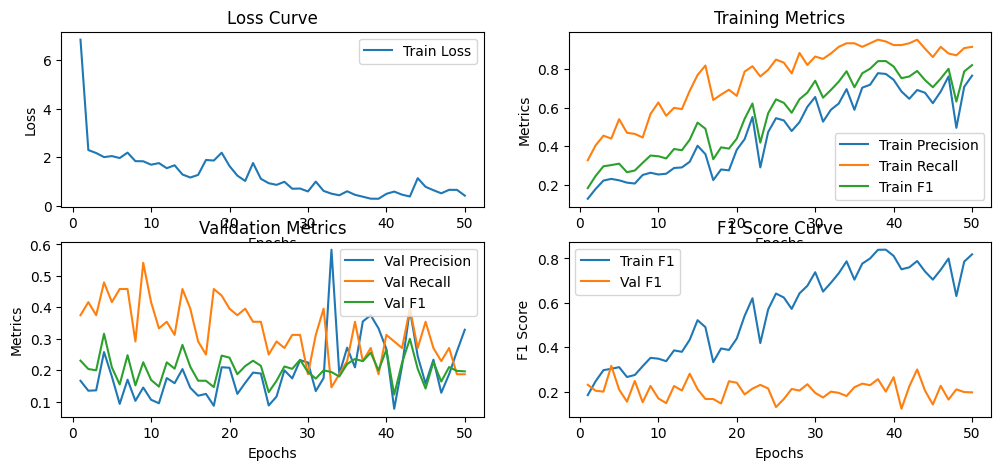

In [51]:
plot_training_curves(metrics_v1param)